In [1]:
import numpy as np 
import pandas as pd 
import cv2
from PIL import Image 
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications import InceptionResNetV2

In [2]:
IMG_WIDTH=300
IMG_HEIGHT=300
IMG_DIM = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 15
IMG_DIR = pathlib.Path('G:\Github\standford-dogs\cropped')
TRAIN_DIR = 'G:/Github/standford-dogs/cropped/train'
VAL_DIR = 'G:/Github/standford-dogs/cropped/validation'

In [4]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.2,
                                              height_shift_range = 0.2
                                                )
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)


In [5]:
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=TRAIN_DIR,
                                        target_size=IMG_DIM,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=VAL_DIR,
                                        target_size=IMG_DIM,batch_size=BATCH_SIZE,
                                        class_mode='categorical')


nb_train = len(train_generator.filenames)
nb_val = len(validation_generator.filenames)

Found 18522 images belonging to 120 classes.
Found 2058 images belonging to 120 classes.


In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow.keras as keras

resnet = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),pooling='max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)


In [7]:
res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [10]:
res_name[-447:]

['block17_4_mixed',
 'block17_4_conv',
 'block17_4',
 'block17_4_ac',
 'conv2d_93',
 'batch_normalization_93',
 'activation_93',
 'conv2d_94',
 'batch_normalization_94',
 'activation_94',
 'conv2d_92',
 'conv2d_95',
 'batch_normalization_92',
 'batch_normalization_95',
 'activation_92',
 'activation_95',
 'block17_5_mixed',
 'block17_5_conv',
 'block17_5',
 'block17_5_ac',
 'conv2d_97',
 'batch_normalization_97',
 'activation_97',
 'conv2d_98',
 'batch_normalization_98',
 'activation_98',
 'conv2d_96',
 'conv2d_99',
 'batch_normalization_96',
 'batch_normalization_99',
 'activation_96',
 'activation_99',
 'block17_6_mixed',
 'block17_6_conv',
 'block17_6',
 'block17_6_ac',
 'conv2d_101',
 'batch_normalization_101',
 'activation_101',
 'conv2d_102',
 'batch_normalization_102',
 'activation_102',
 'conv2d_100',
 'conv2d_103',
 'batch_normalization_100',
 'batch_normalization_103',
 'activation_100',
 'activation_103',
 'block17_7_mixed',
 'block17_7_conv',
 'block17_7',
 'block17_7_ac',


In [11]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-447:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout

num_classes = 120

model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 1536)              54336736  
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 120)               123000    
Total params: 57,083,224
Trainable params: 48,604,088
Non-trainable params: 8,479,136
__________________________________

In [16]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                              restore_best_weights=False
                                              )


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=5,
                                   verbose=1,
                                   min_delta=1e-3,min_lr = 1e-6,
                                   )

In [17]:
model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=num_classes)])

In [18]:
model.fit(train_generator,steps_per_epoch=np.ceil(float(nb_train) / float(BATCH_SIZE)),
                        epochs = 100,callbacks=[early_stop,reduce_lr],
                          validation_steps=np.ceil(float(nb_val) / float(BATCH_SIZE)),
                        validation_data = validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1235.0 steps, validate for 138.0 steps
Epoch 1/100
1235/1235 [==============================] - 522s 423ms/step - loss: 2.5089 - accuracy: 0.4526 - f1_score: 0.4500 - val_loss: 0.9009 - val_accuracy: 0.7765 - val_f1_score: 0.7534
Epoch 2/100
1235/1235 [==============================] - 515s 417ms/step - loss: 1.1973 - accuracy: 0.7033 - f1_score: 0.6986 - val_loss: 0.8209 - val_accuracy: 0.7809 - val_f1_score: 0.7704
Epoch 3/100
1235/1235 [==============================] - 538s 436ms/step - loss: 0.9288 - accuracy: 0.7588 - f1_score: 0.7554 - val_loss: 0.9369 - val_accuracy: 0.7886 - val_f1_score: 0.7781
Epoch 4/100
1235/1235 [==============================] - 534s 432ms/step - loss: 0.7885 - accuracy: 0.7945 - f1_score: 0.7910 - val_loss: 0.8683 - val_accuracy: 0.7809 - val_f1_score: 0.7652
Epoch 5/100
1235/1235 [==============================] - 512s 415ms/step - loss: 0.6710 - accuracy: 0.8185 - f1_score: 0.8160 - val_loss:

In [19]:
def get_diagnostic_plot(model,name):
    training_loss = model.history.history[name]
    test_loss = model.history.history[f'val_{name}']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend([f'Training {name}', f'Val {name}'])
    plt.xlabel('Epoch')
    plt.ylabel(name)

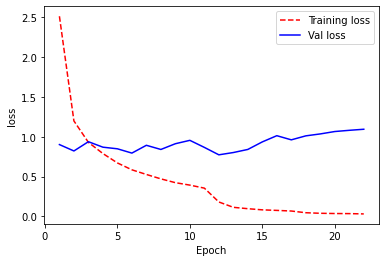

In [20]:
get_diagnostic_plot(model,'loss')

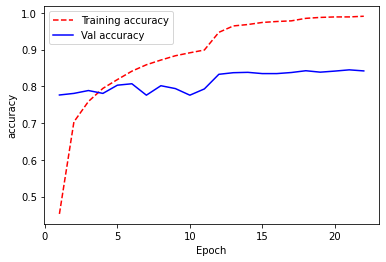

In [21]:
get_diagnostic_plot(model,'accuracy')

In [22]:
save_path = 'G:/Github/Dogs_breed_classification/Incepresnetv2_2/'
tf.keras.models.save_model(model,save_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: G:/Github/Dogs_breed_classification/Incepresnetv2_2/assets


Not bad a performance, significnalty improved v.s. resnet 50 with more trained layers

we want to improve the model further by added more regularization to it

We can try different drop out or data augmentation

Our next notebook will focus on a slightly deeper with more drop out and add more data augmentation to it